In [1]:
import pathlib
import random
from typing import Literal
import math


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
USE_ACCELERATOR = True
TORCH_SEED = 2147483647
SEED = 42
NAMES_FILE = "names.txt"
TERM_TOK = "."

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1.0

# hyperparams
CONTEXT_SIZE = 8
EMBEDDING_SIZE = 24
HIDDEN_SIZE = 128
NUM_LAYERS = 5
BATCH_SIZE = 128
LEARNING_RATE = 1e-1
NUM_EPOCHS = 10

random.seed(SEED)
torch.manual_seed(TORCH_SEED)

device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available() and USE_ACCELERATOR
    else torch.device("cpu")
)
device

device(type='cuda')

In [ ]:
# mosly a copy of torch Linear impl
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # stored as transpose because forward pass is x @ W.T
        self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # pytorch's weird default init, prolly from torch7 days
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        nn.init.uniform_(self.weight, a=-bound, b=bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, a=-bound, b=bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return "in_features={}, out_features={}, bias={}".format(
            self.in_features, self.out_features, self.bias is not None
        )


class BatchNorm1d(nn.Module):
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-05,
        momentum: float | None = 0.1,
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # for simplicity
        self.affine = True
        self.track_running_stats = True
        # parameters
        self.weight = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        self.bias = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        # buffers
        self.running_mean: torch.Tensor | None
        self.running_var: torch.Tensor | None
        self.register_buffer("running_mean", torch.zeros(num_features, **factory_kwargs))
        self.register_buffer("running_var", torch.ones(num_features, **factory_kwargs))
        self.reset_parameters()

    def reset_running_stats(self) -> None:
        if self.running_mean and self.running_var:
            self.running_mean.zero_()
            self.running_var.fill_(1)

    def reset_parameters(self) -> None:
        self.reset_running_stats()
        torch.nn.init.ones_(self.weight)
        torch.nn.init.zeros_(self.bias)

    def extra_repr(self) -> str:
        return "{num_features}, eps={eps}, momentum={momentum}, affine={affine}, track_running_stats={track_running_stats}".format(
            **self.__dict__
        )

    def _check_input_dim(self, input: torch.Tensor) -> None:
        if input.dim() != 2 and input.dim() != 3:
            raise ValueError(f"expected 2D or 3D input (got {input.dim()}D input)")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        self._check_input_dim(input)
        # training mode, use batch stats and accumulate
        # eval mode, use running stats frozen when training finshed
        if self.training:
            xstd, xmean = torch.std_mean(
                input, dim=((0,) if input.dim() == 2 else (0, 1)), keepdim=True, unbiased=False
            )
            xvar = xstd**2
            # no need torch no_grad because buffers are not parameters
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        input_hat = (input - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        return self.weight * input_hat + self.bias


class Tanh(nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.tanh(input)

In [4]:
# build the dataset
class TrigramDataset(data.Dataset):
    def __init__(self, words: list[str], context_size: int, stoi: dict[str, int], terminal_token: str):
        self.context_size = context_size
        self.stoi = stoi
        contexts = []
        labels = []
        for word in words:
            context: list[int] = [0] * context_size
            for ch in word + terminal_token:
                ix = stoi[ch]
                contexts.append(context.copy())
                labels.append(ix)
                context = context[1:] + [ix]
        self.contexts = torch.tensor(contexts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, idx: int | list[int] | torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return self.contexts[idx], self.labels[idx]


words = [line.strip() for line in pathlib.Path(NAMES_FILE).open("r").readlines()]
random.shuffle(words)
chars = [TERM_TOK] + sorted(list(set("".join(words))))
vocab_size = len(chars)
stoi = {s: i for i, s in enumerate(chars)}
itos = chars


n1 = int(TRAIN_SPLIT * len(words))
n2 = int((TRAIN_SPLIT + VAL_SPLIT) * len(words))

train_dataset = TrigramDataset(words[:n1], CONTEXT_SIZE, stoi, TERM_TOK)
dev_dataset = TrigramDataset(words[n1:n2], CONTEXT_SIZE, stoi, TERM_TOK)
test_dataset = TrigramDataset(words[n2:], CONTEXT_SIZE, stoi, TERM_TOK)

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

for X, y in test_dataloader:
    print(f"shape of X [B, C]: {X.shape}")
    print(f"shape of y: {y.shape} {y.dtype}")
    break
print(f"vocab size: {vocab_size}")
print(f"train dataset size: {len(train_dataset)}")
print(f"dev dataset size: {len(dev_dataset)}")
print(f"test dataset size: {len(test_dataset)}")

shape of X [B, C]: torch.Size([128, 8])
shape of y: torch.Size([128]) torch.int64
vocab size: 27
train dataset size: 182625
dev dataset size: 22655
test dataset size: 22866


In [5]:
from typing import Callable


class Lambda(nn.Module):
    def __init__(self, func: Callable[[torch.Tensor], torch.Tensor]) -> None:
        super().__init__()
        self.func = func

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.func(x)


def fc_layer(in_size: int, out_size: int) -> nn.Sequential:
    """Returns a stack of linear->norm->tanh layers."""
    return nn.Sequential(
        Linear(in_size, out_size, bias=False),
        BatchNorm1d(out_size),
        Tanh(),
    )


class FlattenConsecutive(nn.Module):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.n = n

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, E = x.shape
        if C % self.n != 0:
            raise ValueError(f"context size {C} is not divisible by concatenantion number {self.n}")
        x = x.view(B, C // self.n, E * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x


class NgramLM(nn.Module):
    def __init__(
        self,
        context_size: int,
        embedding_dim: int,
        vocab_size: int,
        *,
        hidden_size: int = HIDDEN_SIZE,
        num_layers: int = NUM_LAYERS,
    ) -> None:
        super().__init__()

        layers = []
        layers.append(fc_layer(context_size * embedding_dim, hidden_size))
        for i in range(num_layers - 1):
            layers.append(fc_layer(hidden_size, hidden_size))
        layers.append(Linear(hidden_size, vocab_size, bias=True))
        # make last layer less confident
        with torch.no_grad():
            for layer in layers:
                if isinstance(layer, Linear):
                    if layer is layers[-1]:
                        layer.weight.mul_(0.1)

        self.model = nn.Sequential(
            # assume batch size 4, context size 8, embedding dim 10, hidden size 200, vocab size 27 for comments
            # 4 8 -> 4 8 10
            nn.Embedding(vocab_size, embedding_dim),
            # 4 8 10 -> 4 4 20
            FlattenConsecutive(2),
            # 4 4 20 @ 20 200 -> 4 4 200
            Linear(embedding_dim * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size),
            Tanh(),
            # 4 4 200 -> 4 2 400
            FlattenConsecutive(2),
            # 4 2 400 @ 400 200 -> 4 2 200
            Linear(hidden_size * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size),
            Tanh(),
            # 4 2 200 -> 4 400
            FlattenConsecutive(2),
            # 4 400 @ 400 200 -> 4 200
            Linear(hidden_size * 2, hidden_size, bias=False),
            BatchNorm1d(hidden_size),
            Tanh(),
            # 4 200 -> 4 27
            Linear(hidden_size, vocab_size, bias=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.model(x)
        return logits


model = NgramLM(CONTEXT_SIZE, EMBEDDING_SIZE, vocab_size, num_layers=1).to(device)
print(model)
print(sum(p.numel() for p in model.parameters()))
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.75 * NUM_EPOCHS)], gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

NgramLM(
  (model): Sequential(
    (0): Embedding(27, 24)
    (1): FlattenConsecutive()
    (2): Linear(in_features=48, out_features=128, bias=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Tanh()
    (5): FlattenConsecutive()
    (6): Linear(in_features=256, out_features=128, bias=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): FlattenConsecutive()
    (10): Linear(in_features=256, out_features=128, bias=False)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Tanh()
    (13): Linear(in_features=128, out_features=27, bias=True)
  )
)
76579


In [ ]:
def train(
    dataloader: data.DataLoader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
    loss_accumulator: list[float] | None = None,
) -> None:
    size = len(dataloader.dataset)
    loss_accumulator = loss_accumulator if loss_accumulator is not None else []
    model.train()  # set train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # forward
        logits = model(X)
        loss = loss_fn(logits, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accumulator.append(loss.log10().item())
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(
    dataloader: data.DataLoader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")


test(test_dataloader, model, loss_fn)

Avg loss: 3.310974 



Epoch 1
-------------------------------
loss: 3.391669  [  128/182625]
loss: 2.355259  [12928/182625]
loss: 2.370358  [25728/182625]
loss: 2.294573  [38528/182625]
loss: 2.332361  [51328/182625]
loss: 2.173553  [64128/182625]
loss: 2.332189  [76928/182625]
loss: 2.263801  [89728/182625]
loss: 2.338452  [102528/182625]
loss: 2.285987  [115328/182625]
loss: 2.294502  [128128/182625]
loss: 2.117096  [140928/182625]
loss: 2.109747  [153728/182625]
loss: 2.168407  [166528/182625]
loss: 2.184024  [179328/182625]
Avg loss: 2.153360 

Epoch 2
-------------------------------
loss: 2.021621  [  128/182625]
loss: 2.099035  [12928/182625]
loss: 2.251834  [25728/182625]
loss: 2.150162  [38528/182625]
loss: 2.138408  [51328/182625]
loss: 2.207445  [64128/182625]
loss: 2.133234  [76928/182625]
loss: 1.953636  [89728/182625]
loss: 2.008338  [102528/182625]
loss: 2.035488  [115328/182625]
loss: 2.359165  [128128/182625]
loss: 2.277066  [140928/182625]
loss: 2.191726  [153728/182625]
loss: 2.173208  [16

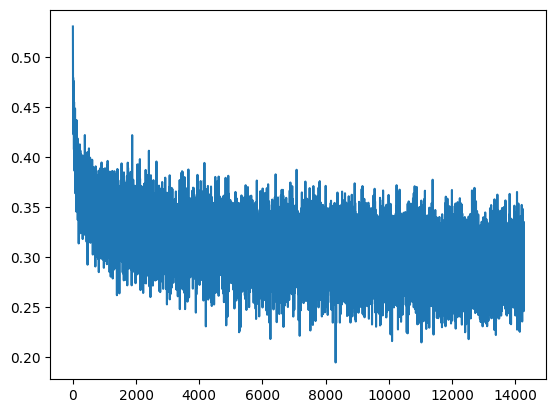

In [8]:
lossi = []

for t in range(NUM_EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, lossi)
    test(test_dataloader, model, loss_fn)

plt.plot(lossi)

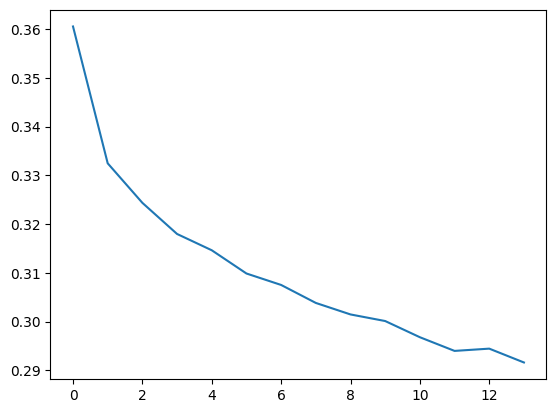

In [9]:
lossi_trunc = lossi[: len(lossi) // 1000 * 1000]
plt.plot(torch.tensor(lossi_trunc).view(-1, 1000).mean(dim=1))

In [12]:
test(train_dataloader, model, loss_fn)
test(dev_dataloader, model, loss_fn)
test(test_dataloader, model, loss_fn)

Avg loss: 1.929517 

Avg loss: 2.028302 

Avg loss: 2.024017 



In [18]:
# sample
model.eval()
with torch.no_grad():
    for _ in range(20):
        context = [0] * CONTEXT_SIZE
        out = ""
        while True:
            logits = model(torch.tensor([context], device=device))
            probs = logits.softmax(dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out += itos[ix]
            if ix == 0:
                break
        print(out)

briekaelo.
ailynn.
tyrine.
arain.
nationa.
zaiden.
neyla.
kailima.
sharissa.
analeen.
lina.
pallys.
medda.
muritana.
caed.
eyu.
khilee.
bahmaya.
fodana.
amonton.
